# LangGraph 101

[LLMs](https://python.langchain.com/docs/concepts/chat_models/) make it possible to embed intelligence into a new class of applications. [LangGraph](https://langchain-ai.github.io/langgraph/) is a framework to help build applications with LLMs. Here, we will overview the basics of LangGraph, explain its benefits, show how to use it to build workflows / agents, and show how it works with [LangChain](https://www.langchain.com/) / [LangSmith](https://docs.smith.langchain.com/).

![ecosystem](./img/ecosystem.png)

## Chat models

[Chat models](https://python.langchain.com/docs/concepts/chat_models/) are the foundation of LLM applications. They are typically accessed through a chat interface that takes a list of [messages](https://python.langchain.com/docs/concepts/messages/) as input and returns a [message](https://python.langchain.com/docs/concepts/messages/) as output. LangChain provides [a standardized interface for chat models](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html), making it easy to [access many different providers](https://python.langchain.com/docs/integrations/chat/).

In [7]:
from dotenv import load_dotenv
load_dotenv("../.env", override=True)

True

In [8]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("openai:gpt-4.1", temperature=0)

In [9]:
llm.invoke??

Signature:
llm.invoke(
    input: 'LanguageModelInput',
    config: 'Optional[RunnableConfig]' = None,
    *,
    stop: 'Optional[list[str]]' = None,
    **kwargs: 'Any',
) -> 'BaseMessage'
Docstring:
Transform a single input into an output.

Args:
    input: The input to the Runnable.
    config: A config to use when invoking the Runnable.
       The config supports standard keys like 'tags', 'metadata' for tracing
       purposes, 'max_concurrency' for controlling how much work to do
       in parallel, and other keys. Please refer to the RunnableConfig
       for more details.

Returns:
    The output of the Runnable.
Source:   
    @override
    def invoke(
        self,
        input: LanguageModelInput,
        config: Optional[RunnableConfig] = None,
        *,
        stop: Optional[list[str]] = None,
        **kwargs: Any,
    ) -> BaseMessage:
        config = ensure_config(config)
        return cast(
            "ChatGeneration",
            self.generate_prompt(
          

## Running the model

The `init_chat_model` interface provides [standardized](https://python.langchain.com/docs/concepts/runnables/) methods for using chat models, which include:
- `invoke()`: A single input is transformed into an output.
- `stream()`: Outputs are [streamed](https://python.langchain.com/docs/concepts/streaming/#stream-and-astream) as they are produced. 

In [10]:
prompt = ''' 
What is an agent?, and how does it differ from a standard LLM? 
How accurate is it to say agents are just two or more llms solving problems together and evaluating each other.

'''

result = llm.invoke(prompt)

In [11]:
type(result)

langchain_core.messages.ai.AIMessage

In [12]:
from rich.markdown import Markdown
Markdown(result.content)

Great questions! Let’s break them down:                                                                            

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                               1. What is an agent?                                                

In the context of AI and LLMs, an agent is a system that can autonomously perceive, reason, and act in an          
environment to achieve specific goals. In practice, an "agent" built on top of an LLM (like GPT-4) is typically a  
software entity that:                                                                                              

 • Receives tasks or goals (e.g., "Book me a flight to Paris").                                                    
 • Plans actions (e.g., search for flights, compare prices).                                                       
 • Interacts with tools or APIs (e.g., web browsers, databases, email).                                            
 • Makes decisions based on feedback or results.                                                                   
 • Iterates until the goal is achieved or a stopping condition is met.                                             

Key point: An agent is not just a model—it’s a system that uses models (often LLMs) as components to reason, plan, 
and act.                                                                                                           

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    2. How does it differ from a standard LLM?                                     

A standard LLM (like GPT-4, Claude, etc.) is a stateless text generator: you give it a prompt, it gives you a      
response. It doesn’t remember past interactions (unless you include them in the prompt), and it doesn’t take       
actions in the world.                                                                                              

An agent, by contrast:                                                                                             

 • Has memory/state: It can remember previous steps, results, or context.                                          
 • Can take actions: It can call APIs, use tools, browse the web, etc.                                             
 • Can plan and iterate: It can break down tasks, try different approaches, and adapt based on feedback.           
 • May use multiple models or tools: It can coordinate between different LLMs, APIs, or software components.       

Summary:                                                                                                           

 • LLM: Text-in, text-out, no memory, no actions.                                                                  
 • Agent: Goal-in, actions-out, with memory, planning, and tool use.                                               

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────
             3. Are agents just two or more LLMs solving problems together and evaluating each other?              

Not exactly.                                                                                                       
While some agent architectures use multiple LLMs (e.g., one to generate solutions, another to critique), the core  
idea of an agent is broader:                                                                                       

 • Agents can use a single LLM (with code to manage memory, planning, and tool use).                               
 • Agents can use multiple LLMs (for self-critique, debate, or specialized tasks).                                 
 • Agents can use non-LLM tools (APIs, databases, calculators, etc.).                                              
 • Agents are defined by their autonomy and

## Tools

[Tools](https://python.langchain.com/docs/concepts/tools/) are utilities that can be called by a chat model. In LangChain, creating tools can be done using the `@tool` decorator, which transforms Python functions into callable tools. It will automatically infer the tool's name, description, and expected arguments from the function definition. You can also use [Model Context Protocol (MCP) servers](https://github.com/langchain-ai/langchain-mcp-adapters) as LangChain-compatible tools. 

In [13]:
from langchain.tools import tool

@tool # using the tool decorator allows us to create tools easily
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

In [14]:
type(write_email)

langchain_core.tools.structured.StructuredTool

In [15]:
write_email.args # the tool attributes like arguements and description are automatically infered. 

{'to': {'title': 'To', 'type': 'string'},
 'subject': {'title': 'Subject', 'type': 'string'},
 'content': {'title': 'Content', 'type': 'string'}}

In [16]:
Markdown(write_email.description)

Write and send an email.

## Tool Calling

Tools can be [called](https://python.langchain.com/docs/concepts/tool_calling/) by LLMs. When a tool is bound to the model, the model can choose to call the tool by returning a structured output with tool arguments. We use the `bind_tools` method to augment an LLM with tools.

![tool-img](img/tool_call_detail.png)

Providers often have [parameters such as `tool_choice`](https://python.langchain.com/docs/how_to/tool_choice/) to enforce calling specific tools. `any` will select at least one of the tools.

In addition, we can [set `parallel_tool_calls=False`](https://python.langchain.com/docs/how_to/tool_calling_parallel/) to ensure the model will only call one tool at a time.

In [17]:
# Connect tools to a chat model
model_with_tools = llm.bind_tools([write_email], tool_choice="any", parallel_tool_calls=False)

#bind tools method allows us to pass a list of tools and some parameters

# The model will now be able to call tools
output = model_with_tools.invoke("Draft a response to my boss (boss@company.ai) about tomorrow's meeting") # is this is point the llm chooses it's tool and decides it needs to use `write_email` tool. The object it returns is the instructions for calling the tool but doesn't actually call it. 

In [18]:
type(output)

langchain_core.messages.ai.AIMessage

In [19]:
output

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u6Dgkm6kmO6ebMSuDSPYC6SD', 'function': {'arguments': '{"to":"boss@company.ai","subject":"Re: Tomorrow\'s Meeting","content":"Dear [Boss\'s Name],\\n\\nThank you for the reminder about tomorrow\'s meeting. I confirm my attendance and look forward to discussing the agenda items. Please let me know if there is anything specific you would like me to prepare or bring to the meeting.\\n\\nBest regards,\\n[Your Name]"}', 'name': 'write_email'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 91, 'prompt_tokens': 67, 'total_tokens': 158, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BnNTrbS5Mk3pP4c5xbpQYzI0rhxIx', 'service_tier': 'd

In [20]:
import pprint



print("=== AI Message Output ===")
print(f"Content: {output.content}")
print(f"Additional kwargs:")
pprint.pprint(output.additional_kwargs, width=100)

# If you want to see tool calls specifically
if output.tool_calls:
    print("\nTool calls:")
    for i, tool_call in enumerate(output.tool_calls, 1):
        print(f"  {i}. Function: {tool_call.get('function', {}).get('name', 'Unknown')}")
        print(f"     Arguments: {tool_call.get('function', {}).get('arguments', {})}")

=== AI Message Output ===
Content: 
Additional kwargs:
{'refusal': None,
 'tool_calls': [{'function': {'arguments': '{"to":"boss@company.ai","subject":"Re: Tomorrow\'s '
                                           'Meeting","content":"Dear [Boss\'s Name],\\n\\nThank '
                                           "you for the reminder about tomorrow's meeting. I "
                                           'confirm my attendance and look forward to discussing '
                                           'the agenda items. Please let me know if there is '
                                           'anything specific you would like me to prepare or '
                                           'bring to the meeting.\\n\\nBest regards,\\n[Your '
                                           'Name]"}',
                              'name': 'write_email'},
                 'id': 'call_u6Dgkm6kmO6ebMSuDSPYC6SD',
                 'type': 'function'}]}

Tool calls:
  1. Function: Unknown
     Argument

In [21]:
output.tool_calls[0] # list of tools the llm wants to call. in this case it's write_email tool 

{'name': 'write_email',
 'args': {'to': 'boss@company.ai',
  'subject': "Re: Tomorrow's Meeting",
  'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and look forward to discussing the agenda items. Please let me know if there is anything specific you would like me to prepare or bring to the meeting.\n\nBest regards,\n[Your Name]"},
 'id': 'call_u6Dgkm6kmO6ebMSuDSPYC6SD',
 'type': 'tool_call'}

In [22]:
# Extract tool calls and execute them
args = output.tool_calls[0]['args'] # extracts the arguments the LLM wants to use. 
args

{'to': 'boss@company.ai',
 'subject': "Re: Tomorrow's Meeting",
 'content': "Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and look forward to discussing the agenda items. Please let me know if there is anything specific you would like me to prepare or bring to the meeting.\n\nBest regards,\n[Your Name]"}

In [23]:
# Call the tool
result = write_email.invoke(args)
Markdown(result)

Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],               

Thank you for the reminder about tomorrow's meeting. I confirm my attendance and look forward to discussing the    
agenda items. Please let me know if there is anything specific you would like me to prepare or bring to the        
meeting.                                                                                                           

Best regards, [Your Name]

while not done:  
    1. LLM decides what to do  
    2. Execute tools (if any)  
    3. Add results to conversation  
    4. Repeat until final answer  

![basic_prompt](img/tool_call.png)

## Workflows
 
There are many patterns for building applications with LLMs. 

[We can embed LLM calls into pre-defined workflows](https://langchain-ai.github.io/langgraph/tutorials/workflows/), giving the system more agency to make decisions. 

As an example, we could add a router step to determine whether to write an email or not.

![workflow_example](img/workflow_example.png)

## Agents

We can further increase agency, allowing the LLM to dynamically direct its own tool usage. 

[Agents](https://langchain-ai.github.io/langgraph/tutorials/workflows/) are typically implemented as tool calling in a loop, where the output of each tool call is used to inform the next action.

![agent_example](img/agent_example.png)

Agents are well suited to open-ended problems where it's difficult to predict the *exact* steps needed in advance.
 
Workflows are often appropriate when the control flow can easily be defined in advance. 

![workflow_v_agent](img/workflow_v_agent.png)

## What is LangGraph? 

[LangGraph](https://langchain-ai.github.io/langgraph/concepts/high_level/) provides low-level supporting infrastructure that sits underneath *any* workflow or agent. 

It does not abstract prompts or architecture, and provides a few benefits:

- **Control**: Make it easy to define and / or combine agents and workflows.
- **Persistence**: Provide a way to persist the state of a graph, which enables both memory and human-in-the-loop.
- **Testing, Debugging, and Deployment**: Provide an easy onramp for testing, debugging, and deploying applications.

### Control

LangGraph lets you define your application as a graph with:

1. *State*: What information do we need to track over the course of the application?
2. *Nodes*: How do we want to update this information over the course of the application?
3. *Edges*: How do we want to connect these nodes together?

We can use the [`StateGraph` class](https://langchain-ai.github.io/langgraph/concepts/low_level/#graphs) to initialize a LangGraph graph with a [`State` object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

`State` defines the schema for information we want to track over the course of the application. 

This can be any object with `getattr()` in python, such as a dictionary, dataclass, or Pydantic object: 

- TypeDict is fastest but doesn’t support defaults
- Dataclass is basically as fast, supports dot syntax `state.foo`, and has defaults. 
- Pydantic is slower (especially with custom validators) but gives type validation.

Each node is simply a python function or typescript code. This gives us full control over the logic inside each node.

They receive the current state, and return a dictionary to update the state.

By default, [state keys are overwritten](https://langchain-ai.github.io/langgraph/how-tos/state-reducers/). 

However, you can [define custom update logic](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers). 

![nodes_edges](img/nodes_edges.png)

Core Concepts You'll Learn:

State - What information to track (like conversation history, user preferences)  
Nodes - Functions that update the state (LLM calls, tool executions)  
Edges - How nodes connect (conditional logic, loops)  

In [24]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

class StateSchema(TypedDict): #building a workflow that tracks request and email data
    request: str
    email: str

workflow = StateGraph(StateSchema) # initialise the state graph with our custom scheme

In [25]:
workflow.schemas[StateSchema]["request"]

In [26]:
from langchain.tools import tool

@tool # using the tool decorator allows us to create tools easily
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"



def write_email_node(state: StateSchema) -> StateSchema: #creation of node 
    # Imperative code that processes the request
    output = model_with_tools.invoke(state["request"])
    args = output.tool_calls[0]['args']
    email = write_email.invoke(args)
    return {"email": email} # this function returns a dictionary with updates state data

# state is the current data in the graph. It's a dictionary with `request` and email keys. As defined above

This function:

Takes current state as input  
Processes it (calls LLM + tools)  
Returns updated state  

Edges connect nodes together. 

We specify the control flow by adding edges and nodes to our state graph. 

In [33]:
workflow = StateGraph(StateSchema)
workflow.add_node("write_email_node", write_email_node) # converts/registers the function into/as a node.  workflow.add_node(node_name,function_name)
workflow.add_edge(START, "write_email_node") # START flows to this node
workflow.add_edge("write_email_node", END) #This node flows to end

#Execution engine: runs the graph
app = workflow.compile()

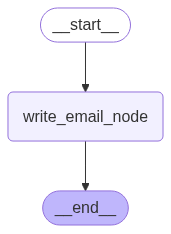

In [35]:
show_graph(app)

In [28]:
app.invoke({"request": "Draft a response to my boss (boss@company.ai) about tomorrow's meeting"}) # pass an inital value to our state here 

{'request': "Draft a response to my boss (boss@company.ai) about tomorrow's meeting",
 'email': "Email sent to boss@company.ai with subject 'Re: Tomorrow's Meeting' and content: Dear [Boss's Name],\n\nThank you for the reminder about tomorrow's meeting. I confirm my attendance and will be prepared with the necessary updates and materials.\n\nPlease let me know if there are any specific topics you would like me to address or if there are any changes to the agenda.\n\nLooking forward to our discussion.\n\nBest regards,\n[Your Name]"}

Routing between nodes can be done [conditionally](https://langchain-ai.github.io/langgraph/concepts/low_level/#conditional-edges) using a simple function. 

The return value of this function is used as the name of the node (or list of nodes) to send the state to next. 

You can optionally provide a dictionary that maps the `should_continue` output to the name of the next node.

In [37]:
from typing import Literal
from langgraph.graph import MessagesState
from email_assistant.utils import show_graph

def call_llm(state: MessagesState) -> MessagesState:
    """Run LLM"""

    output = model_with_tools.invoke(state["messages"])
    return {"messages": [output]} # append to the list of messages instead of overwriting

def run_tool(state: MessagesState):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        observation = write_email.invoke(tool_call["args"])
        result.append({"role": "tool", "content": observation, "tool_call_id": tool_call["id"]})
    return {"messages": result}

def should_continue(state: MessagesState) -> Literal["run_tool", "__end__"]:#
    """ This is a conditional edge with returns the name of the next node you want to go to"""
    """Route to tool handler, or end if Done tool called"""
    
    # Get the last message
    messages = state["messages"] #list of messages
    last_message = messages[-1]
    
    # If the last message is a tool call, check if it's a Done tool call
    if last_message.tool_calls: #check if last message is a tool call 
        return "run_tool" #return the name of the next node to go to 'run_tool'
    # Otherwise, we stop (reply to the user)
    return END

workflow = StateGraph(MessagesState) #MessageState is a pre-built state object in LangGraph with a single key, messages
workflow.add_node("call_llm", call_llm)
workflow.add_node("run_tool", run_tool)
workflow.add_edge(START, "call_llm")
workflow.add_conditional_edges("call_llm", should_continue, {"run_tool": "run_tool", END: END}) #if the agent is making a tool call we run it, if not we exit the agent and end the loop
workflow.add_edge("run_tool", END)

# Run the workflow
app = workflow.compile()

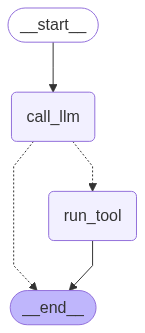

In [38]:
show_graph(app)

In [31]:
result = app.invoke({"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]})
for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_uO5uKVaeSDgdPaOPqKzogOUD)
 Call ID: call_uO5uKVaeSDgdPaOPqKzogOUD
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt!
    content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the event.

Please let me know if there are any next steps or additional details I should be aware of.

Best regards,

[Your Name]
================================= Tool Message =================================

Email sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt!' and content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the event.

Please let

With these low level components, you can build many many different workflows and agents. See [this tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/)!

Because agents are such a common pattern, [LangGraph](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built) has [a pre-built agent](https://langchain-ai.github.io/langgraph/agents/overview/?ref=blog.langchain.dev#what-is-an-agent) abstraction.

With LangGraph's [pre-built method](https://langchain-ai.github.io/langgraph/tutorials/workflows/#pre-built), we just pass in the LLM, tools, and prompt. 

In [32]:
from langgraph.prebuilt import create_react_agent

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided."  
)

# Run the agent
result = agent.invoke(
    {"messages": [{"role": "user", "content": "Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!"}]}
)

for m in result["messages"]:
    m.pretty_print()

================================ Human Message =================================

Draft a response to my boss (boss@company.ai) confirming that I want to attend Interrupt!
================================== Ai Message ==================================
Tool Calls:
  write_email (call_3cwt26mLSZLmLpiQhr5VbYua)
 Call ID: call_3cwt26mLSZLmLpiQhr5VbYua
  Args:
    to: boss@company.ai
    subject: Confirmation: Attendance at Interrupt!
    content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the event.

Please let me know if there are any next steps or additional details I should be aware of.

Best regards,

[Your Name]
================================= Tool Message =================================
Name: write_email

Email sent to boss@company.ai with subject 'Confirmation: Attendance at Interrupt!' and content: Hi,

Thank you for letting me know about Interrupt! I would like to confirm that I am interested in attending the 

### Persistence

#### Threads

It can be very useful to allow agents to pause during long running tasks.

LangGraph has a built-in persistence layer, implemented through checkpointers, to enable this. 

When you compile graph with a checkpointer, the checkpointer saves a [checkpoint](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpoints) of the graph state at every step. 

Checkpoints are saved to a thread, which can be accessed after graph execution completes.

![checkpointer](img/checkpoints.png)

We compile the graph with a [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries).


In [39]:
from langgraph.checkpoint.memory import InMemorySaver

agent = create_react_agent(
    model=llm,
    tools=[write_email],
    prompt="Respond to the user's request using the tools provided.",
    checkpointer=InMemorySaver()
)

config = {"configurable": {"thread_id": "1"}}
result = agent.invoke({"messages": [{"role": "user", "content": "What are some good practices for writing emails?"}]}, config)
                    

In [40]:
# Get the latest state snapshot
config = {"configurable": {"thread_id": "1"}}
state = agent.get_state(config)
for message in state.values['messages']:
    message.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and Direct:** Get to the point quickly. Use short paragraphs and avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors.

5. **Be Polite and Professional:** Use courteous language and maintain a professional tone, even if the email is informal.

6. **Structure Your Email:** Use paragraphs, bullet points, or numbered lists to organize information clearly.

7. **State Your Purpose Early:** Let the rec

In [41]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "Good, let's use lesson 3 to craft a response to my boss confirming that I want to attend Interrupt"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and Direct:** Get to the point quickly. Use short paragraphs and avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors.

5. **Be Polite and Professional:** Use courteous language and maintain a professional tone, even if the email is informal.

6. **Structure Your Email:** Use paragraphs, bullet points, or numbered lists to organize information clearly.

7. **State Your Purpose Early:** Let the rec

In [42]:
# Continue the conversation
result = agent.invoke({"messages": [{"role": "user", "content": "I like this, let's write the email to boss@company.ai"}]}, config)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

What are some good practices for writing emails?
================================== Ai Message ==================================

Here are some good practices for writing effective emails:

1. **Use a Clear Subject Line:** Make your subject concise and informative so the recipient knows what to expect.

2. **Greet Appropriately:** Start with a polite greeting, such as “Hello [Name],” or “Dear [Name],” depending on the formality.

3. **Be Concise and Direct:** Get to the point quickly. Use short paragraphs and avoid unnecessary details.

4. **Use Proper Grammar and Spelling:** Proofread your email to ensure it is free of errors.

5. **Be Polite and Professional:** Use courteous language and maintain a professional tone, even if the email is informal.

6. **Structure Your Email:** Use paragraphs, bullet points, or numbered lists to organize information clearly.

7. **State Your Purpose Early:** Let the rec

#### Interrupts

In LangGraph, we can also use [interrupts](https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/wait-user-input/) to stop graph execution at specific points.

Often this is used to collect input from a user and continue execution with collected input.

In [27]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

from langgraph.types import Command, interrupt
from langgraph.checkpoint.memory import InMemorySaver

class State(TypedDict):
    input: str
    user_feedback: str

def step_1(state):
    print("---Step 1---")
    pass

def human_feedback(state):
    print("---human_feedback---")
    feedback = interrupt("Please provide feedback:")
    return {"user_feedback": feedback}

def step_3(state):
    print("---Step 3---")
    pass

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = InMemorySaver()

# Add
graph = builder.compile(checkpointer=memory)

In [ ]:
show_graph(graph)

In [ ]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="updates"):
    print(event)
    print("\n")

To resume from an interrupt, we can use [the `Command` object](https://langchain-ai.github.io/langgraph/how-tos/command/). 

We'll use it to resume the graph from the interrupted state, passing the value to return from the interrupt call to `resume`. 

In [ ]:
# Continue the graph execution
for event in graph.stream(
    Command(resume="go to step 3!"),
    thread,
    stream_mode="updates",
):
    print(event)
    print("\n")

### Tracing

When we are using LangChain or LangGraph, LangSmith logging [will work out of the box](https://docs.smith.langchain.com/observability/how_to_guides/trace_with_langgraph) with the following environment variables set:

```
export LANGSMITH_TRACING=true
export LANGSMITH_API_KEY="<your-langsmith-api-key>"
```

Here is the LangSmith trace from above agent execution:

https://smith.langchain.com/public/6f77014f-d054-44ed-aa2c-8b06ceab689f/r

We can see that the agent is able to continue the conversation from the previous state because we used a checkpointer.

### Deployment

We can also deploy our graph using [LangGraph Platform](https://langchain-ai.github.io/langgraph/concepts/langgraph_platform/). 

This creates a server [with an API](https://langchain-ai.github.io/langgraph/cloud/reference/api/api_ref.html) that we can use to interact with our graph and an interactive IDE, LangGraph [Studio](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/).

We simply need to ensure our project has [a structure](https://langchain-ai.github.io/langgraph/concepts/application_structure/) like this:

```
my-app/
├── src/email_assistant # all project code lies within here
│   └── langgraph101.py # code for constructing your graph
├── .env # environment variables
├── langgraph.json  # configuration file for LangGraph
└── pyproject.toml # dependencies for your project
```

The `langgraph.json` file specifies the dependencies, graphs, environment variables, and other settings required to start a LangGraph server.

To test this, let's deploy `langgraph_101.py`. We have it in our `langgraph.json` file in this repo:

```
 "langgraph101": "./src/email_assistant/langgraph_101.py:app",
```

For LangGraph Platform, there are a range of [deployment options](https://langchain-ai.github.io/langgraph/tutorials/deployment/): 
 
* Local deployments can be started with `langgraph dev` from the root directory of the repo. Checkpoints are saved to the local filesystem.
* There are also various [self-hosted options](https://langchain-ai.github.io/langgraph/tutorials/deployment/#other-deployment-options). 
* For hosted deployments, checkpoints are saved to Postgres using a postgres [checkpointer](https://langchain-ai.github.io/langgraph/concepts/persistence/#checkpointer-libraries). 

Test: 
```
Draft a response to my boss (boss@company.ai) confirming that I want to attent Interrupt!
```

Here we can see a visualization of the graph as well as the graph state in Studio.

![langgraph_studio](img/langgraph_studio.png)

Also, you can see API docs for the local deployment here:

http://127.0.0.1:2024/docs